In [ ]:
!pip install q gast==0.3.3
!pip install q keras==2.3.1
!pip install q tensorflow==2.1
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
!pip install git+https://github.com/qubvel/segmentation_models

     |████████████████████████████████| 378kB 5.6MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 450kB 37.6MB/s 
     |████████████████████████████████| 3.9MB 18.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=3442794940d815f21bf7999b20897f53ae3b361c03ebe4454684d3f109cb4143
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: 

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-fpvgvry4
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-fpvgvry4
     |████████████████████████████████| 952kB 5.2MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.2-cp37-none-any.whl size=93094 sha256=914808f86ae036687f403955e8c1238200a2197419c331854e30fe01f6215f30
  Stored in directory: /tmp/pip-ephem-wheel-cache-jfoq2c61/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-pxsbsrkz
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-pxsbsrkz
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp37-none-any.whl size=33794 sha256=dc0b74303afb1fd526e1c91f3a704aa9f1dbdad196069f7d46f4b109be9bb61e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3f7a6kxg/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import math
import glob
import cv2
from itertools import chain
import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import albumentations as A
import segmentation_models as sm 

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# DATA_DIR = './drive/My Drive/Colab Notebooks/TACK/Crack_Segmentation_Dataset_small'
# DATA_DIR = '/drive/My Drive/Colab Notebooks/TACK/Crack_Segmentation_Dataset'
DATA_DIR = './drive/My Drive/Colab Notebooks/TACK/data_deepcrack'
x_train_dir = os.path.join(DATA_DIR, 'train/image')
y_train_dir = os.path.join(DATA_DIR, 'train/mask')

x_valid_dir = os.path.join(DATA_DIR, 'test/image')
y_valid_dir = os.path.join(DATA_DIR, 'test/mask')

In [ ]:
def visualize(**images):
    """Plot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    # plt.savefig('./drive/My Drive/Colab Notebooks/TACK/Large/result' + ' '.join(name.split('_')).title() + '.png')

In [ ]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['crack'] #, 'building', 'pole', 'road', 'pavement', 
               #'tree', 'signsymbol', 'fence', 'car', 
               #'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None,
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_paths = []
        self.masks_paths = []
        # for name in os.listdir(images_dir):
        #     if os.path.isfile(os.path.join(masks_dir, name.split('.')[0]+'.jpg')):
        #         self.images_paths.append(os.path.join(images_dir, name))
        #         self.masks_paths.append(os.path.join(masks_dir, name.split('.')[0]+'.jpg'))
        #     elif os.path.isfile(os.path.join(masks_dir, name.split('.')[0]+'.png')):
        #         self.images_paths.append(os.path.join(images_dir, name))
        #         self.masks_paths.append(os.path.join(masks_dir, name.split('.')[0]+'.png'))
        #     elif os.path.isfile(os.path.join(masks_dir, name.split('.')[0]+'.bmp')):
        #         self.images_paths.append(os.path.join(images_dir, name))
        #         self.masks_paths.append(os.path.join(masks_dir, name.split('.')[0]+'.gif'))
        #     else:
        #         continue
        
        for name in os.listdir(images_dir):
            self.images_paths.append(os.path.join(images_dir, name))
            self.masks_paths.append(os.path.join(masks_dir, name + '___fuse.png'))
        
        # convert str names to class values on masks
        self.class_values = [255] #[self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        # print(self.images_paths[i])
        image = cv2.imread(self.images_paths[i])
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # print(self.masks_paths[i])
        # mask = cv2.imread(self.masks_paths[i], 0)
        mask = cv2.imread(self.masks_paths[i], cv2.IMREAD_GRAYSCALE)
        mask = cv2.threshold(mask, 125, 255, cv2.THRESH_BINARY)[1]

        #print(np.min(mask),np.max(mask), np.median(mask))
        #mask[mask>0] = 1
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        # if (image.shape[0] > image.shape[1]):
        #     image = cv2.flip(cv2.transpose(image), 1)
        #     mask = cv2.flip(cv2.transpose(mask), 1)
        return image, mask
        
    def __len__(self):
        return len(self.images_paths)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

600
(384, 544, 3) (384, 544, 1)


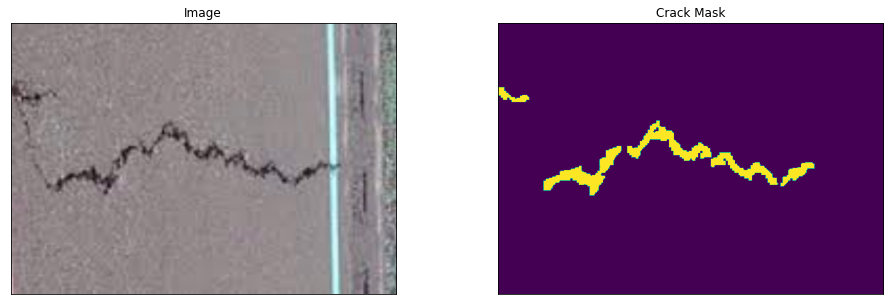

474
(384, 544, 3) (384, 544, 1)


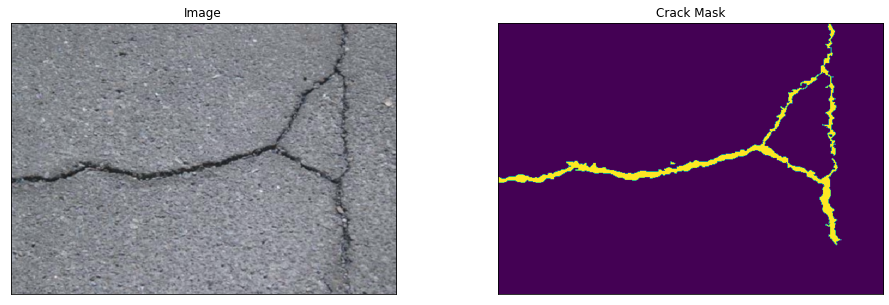

In [ ]:
dataset_train = Dataset(x_train_dir, y_train_dir, classes=['crack'])
print(len(dataset_train))
image, mask = dataset_train[0] # get some sample
print(image.shape, mask.shape)
visualize(
    image=image,
    crack_mask=mask[..., 0].squeeze(),
)
train_dataloader = Dataloder(dataset_train, batch_size=5, shuffle=True)

dataset_valid = Dataset(x_valid_dir, y_valid_dir, classes=['crack'])
print(len(dataset_valid))
image, mask = dataset_valid[0] # get some sample
print(image.shape, mask.shape)
visualize(
    image=image, 
    crack_mask=mask[..., 0].squeeze(),
)
valid_dataloader = Dataloder(dataset_valid, batch_size=5, shuffle=True)

In [ ]:
BACKBONE = 'resnet18' #cambiare
BATCH_SIZE = 5 #aumentare batch
CLASSES = ['crack']
LR = 0.00001
EPOCHS = 50
TEST_MODEL_NAME = None

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(TEST_MODEL_NAME, save_weights_only=True, save_best_only=True,  monitor='val_f1-score', mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-6)
]

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    # callbacks=callbacks, 
    # validation_data=valid_dataloader, 
    # validation_steps=len(valid_dataloader),
)
model.save_weights(os.path.join(DATA_DIR, 'best_model.h5'))

Epoch 1/50
120/120 [==============================] - 44s 369ms/step - loss: 0.7398 - iou_score: 0.3669
Epoch 2/50
120/120 [==============================] - 39s 326ms/step - loss: 0.4675 - iou_score: 0.5863
Epoch 3/50
120/120 [==============================] - 40s 330ms/step - loss: 0.4420 - iou_score: 0.6109
Epoch 4/50
120/120 [==============================] - 40s 332ms/step - loss: 0.4123 - iou_score: 0.6372
Epoch 5/50
120/120 [==============================] - 40s 335ms/step - loss: 0.3977 - iou_score: 0.6493
Epoch 6/50
120/120 [==============================] - 40s 337ms/step - loss: 0.3861 - iou_score: 0.6603
Epoch 7/50
120/120 [==============================] - 40s 337ms/step - loss: 0.3655 - iou_score: 0.6783
Epoch 8/50
120/120 [==============================] - 40s 337ms/step - loss: 0.3480 - iou_score: 0.6925
Epoch 9/50
120/120 [==============================] - 40s 336ms/step - loss: 0.3432 - iou_score: 0.6971
Epoch 10/50
120/120 [==============================] - 40s 336ms

In [ ]:
# Fine Tuned

BACKBONE = 'resnet18' #cambiare
BATCH_SIZE = 5 #aumentare batch
CLASSES = ['crack']
LR = 0.00001
EPOCHS = 50
TEST_MODEL_NAME = None

# define model
model = sm.Unet(BACKBONE, encoder_freeze=True, encoder_weights='imagenet', activation='sigmoid')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint(TEST_MODEL_NAME, save_weights_only=True, save_best_only=True,  monitor='val_f1-score', mode='max'),
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-6)
]

# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=2, 
    # callbacks=callbacks, 
    # validation_data=valid_dataloader, 
    # validation_steps=len(valid_dataloader),
)

# sm.utils.set_trainable(model)
for layer in model.layers:
    layer.trainable = True

model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=50, 
    # callbacks=callbacks, 
    # validation_data=valid_dataloader, 
    # validation_steps=len(valid_dataloader),
)

model.save_weights(os.path.join(DATA_DIR, 'best_model_fine_tuned.h5'))

Epoch 1/2
120/120 [==============================] - 42s 354ms/step - loss: 0.7040 - iou_score: 0.3865
Epoch 2/2
120/120 [==============================] - 37s 308ms/step - loss: 0.4319 - iou_score: 0.6167
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


120/120 [==============================] - 37s 308ms/step - loss: 0.3833 - iou_score: 0.6596
Epoch 2/50
120/120 [==============================] - 37s 307ms/step - loss: 0.3554 - iou_score: 0.6850
Epoch 3/50
120/120 [==============================] - 37s 307ms/step - loss: 0.3318 - iou_score: 0.7048
Epoch 4/50
120/120 [==============================] - 37s 307ms/step - loss: 0.3160 - iou_score: 0.7192
Epoch 5/50
120/120 [==============================] - 37s 307ms/step - loss: 0.2936 - iou_score: 0.7380
Epoch 6/50
120/120 [==============================] - 37s 306ms/step - loss: 0.2908 - iou_score: 0.7420
Epoch 7/50
120/120 [==============================] - 37s 307ms/step - loss: 0.2803 - iou_score: 0.7503
Epoch 8/50
120/120 [==============================] - 37s 307ms/step - loss: 0.2665 - iou_score: 0.7618
Epoch 9/50
120/120 [==============================] - 37s 307ms/step - loss: 0.2531 - iou_score: 0.7733
Epoch 10/50
120/120 [==============================] - 37s 307ms/step - los

In [ ]:
DATA_DIR = './drive/My Drive/Colab Notebooks/TACK/Small'
images_dir = os.path.join(DATA_DIR, 'image')
masks_dir = os.path.join(DATA_DIR, 'fuse')
SAVE_DIR = './drive/My Drive/Colab Notebooks/TACK/Small_Tiles'
save_images_dir = os.path.join(SAVE_DIR, 'image')
save_masks_dir = os.path.join(SAVE_DIR, 'fuse')
for name in os.listdir(images_dir):
    print(name)
    image = cv2.imread(os.path.join(images_dir, name))
    mask = cv2.imread(os.path.join(masks_dir, name+'___fuse.png'), cv2.IMREAD_GRAYSCALE)
    mask = cv2.threshold(mask, 125, 255, cv2.THRESH_BINARY)[1]
    if image.shape[0] < 384 or image.shape[1] < 544:
        print('Error: The testing image is too small')
    numx = math.ceil(image.shape[1] / 544)
    numy = math.ceil(image.shape[0] / 384)
    print(numx)
    print(numy)
    for i in range(numx):
        for j in range(numy):
            if i < numx - 1:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, i*544, (i+1)*544)
                    image_tile = image[j*384: (j+1)*384, i*544: (i+1)*544]
                    mask_tile = mask[j*384: (j+1)*384, i*544: (i+1)*544]
                    # print(image_tile.shape)
                    if np.all(mask_tile == 0):
                        print(os.path.join(save_images_dir, name+'_'+str(i)+'_'+str(j)) + ' passed')
                    else:
                        cv2.imwrite(os.path.join(save_images_dir, name+'_'+str(i)+'_'+str(j))+'.bmp', image_tile)
                        cv2.imwrite(os.path.join(save_masks_dir, name+'_'+str(i)+'_'+str(j)+'.bmp'+'___fuse.png'), mask_tile)
                else:
                    # print(image.shape[0]-384, image.shape[0], i*544, (i+1)*544)
                    image_tile = image[image.shape[0]-384: image.shape[0], i*544: (i+1)*544]
                    mask_tile = mask[image.shape[0]-384: image.shape[0], i*544: (i+1)*544]
                    # print(image_tile.shape)
                    if np.all(mask_tile == 0):
                        print(os.path.join(save_images_dir, name+'_'+str(i)+'_'+str(j)) + ' passed')
                    else:
                        cv2.imwrite(os.path.join(save_images_dir, name+'_'+str(i)+'_'+str(j))+'.bmp', image_tile)
                        cv2.imwrite(os.path.join(save_masks_dir, name+'_'+str(i)+'_'+str(j)+'.bmp'+'___fuse.png'), mask_tile)
            else:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, image.shape[1]-544, image.shape[1])
                    image_tile = image[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]]
                    mask_tile = mask[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    if np.all(mask_tile == 0):
                        print(os.path.join(save_images_dir, name+'_'+str(i)+'_'+str(j)) + ' passed')
                    else:
                        cv2.imwrite(os.path.join(save_images_dir, name+'_'+str(i)+'_'+str(j))+'.bmp', image_tile)
                        cv2.imwrite(os.path.join(save_masks_dir, name+'_'+str(i)+'_'+str(j)+'.bmp'+'___fuse.png'), mask_tile)
                else:
                    # print(image.shape[0]-384, image.shape[0], image.shape[1]-544, image.shape[1])
                    image_tile = image[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]]
                    mask_tile = mask[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    if np.all(mask_tile == 0):
                        print(os.path.join(save_images_dir, name+'_'+str(i)+'_'+str(j)) + ' passed')
                    else:
                        cv2.imwrite(os.path.join(save_images_dir, name+'_'+str(i)+'_'+str(j))+'.bmp', image_tile)
                        cv2.imwrite(os.path.join(save_masks_dir, name+'_'+str(i)+'_'+str(j)+'.bmp'+'___fuse.png'), mask_tile)


Camera6_block2-gata1_2017-10-10_231224_000013.bmp
5
5
./drive/My Drive/Colab Notebooks/TACK/Small_Tiles/image/Camera6_block2-gata1_2017-10-10_231224_000013.bmp_0_0 passed
./drive/My Drive/Colab Notebooks/TACK/Small_Tiles/image/Camera6_block2-gata1_2017-10-10_231224_000013.bmp_0_1 passed
./drive/My Drive/Colab Notebooks/TACK/Small_Tiles/image/Camera6_block2-gata1_2017-10-10_231224_000013.bmp_0_2 passed
./drive/My Drive/Colab Notebooks/TACK/Small_Tiles/image/Camera6_block2-gata1_2017-10-10_231224_000013.bmp_0_3 passed
./drive/My Drive/Colab Notebooks/TACK/Small_Tiles/image/Camera6_block2-gata1_2017-10-10_231224_000013.bmp_0_4 passed
./drive/My Drive/Colab Notebooks/TACK/Small_Tiles/image/Camera6_block2-gata1_2017-10-10_231224_000013.bmp_1_0 passed
./drive/My Drive/Colab Notebooks/TACK/Small_Tiles/image/Camera6_block2-gata1_2017-10-10_231224_000013.bmp_1_1 passed
./drive/My Drive/Colab Notebooks/TACK/Small_Tiles/image/Camera6_block2-gata1_2017-10-10_231224_000013.bmp_1_2 passed
./drive/My

In [ ]:
FINE_TUNE_DIR = './drive/My Drive/Colab Notebooks/TACK/Small_Tiles'
x_fine_tune_dir = os.path.join(FINE_TUNE_DIR, 'image')
y_fine_tune_dir = os.path.join(FINE_TUNE_DIR, 'fuse')

dataset_train = Dataset(x_fine_tune_dir, y_fine_tune_dir, classes=['crack'])
train_dataloader = Dataloder(dataset_train, batch_size=5, shuffle=True)


# define optomizer
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=20, 
)

model.save_weights(os.path.join(FINE_TUNE_DIR, 'best_model_fine_tuned_with_Small.h5'))

Epoch 1/20
16/16 [==============================] - 11s 682ms/step - loss: 0.8066 - iou_score: 0.1399 - f1-score: 0.2344
Epoch 2/20
16/16 [==============================] - 5s 319ms/step - loss: 0.6526 - iou_score: 0.2389 - f1-score: 0.3734
Epoch 3/20
16/16 [==============================] - 5s 319ms/step - loss: 0.5791 - iou_score: 0.2931 - f1-score: 0.4427
Epoch 4/20
16/16 [==============================] - 5s 318ms/step - loss: 0.5318 - iou_score: 0.3306 - f1-score: 0.4870
Epoch 5/20
16/16 [==============================] - 5s 319ms/step - loss: 0.4991 - iou_score: 0.3596 - f1-score: 0.5192
Epoch 6/20
16/16 [==============================] - 5s 319ms/step - loss: 0.4737 - iou_score: 0.3815 - f1-score: 0.5439
Epoch 7/20
16/16 [==============================] - 5s 321ms/step - loss: 0.4529 - iou_score: 0.4000 - f1-score: 0.5644
Epoch 8/20
16/16 [==============================] - 5s 321ms/step - loss: 0.4362 - iou_score: 0.4152 - f1-score: 0.5804
Epoch 9/20
16/16 [=====================

In [ ]:
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

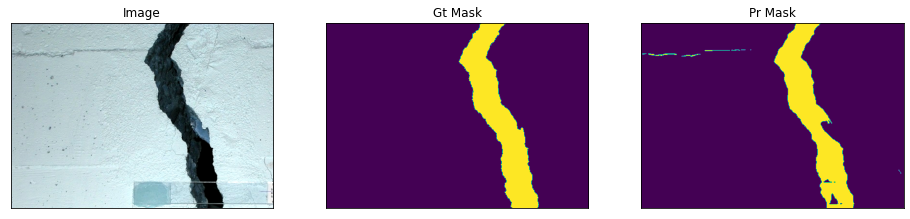

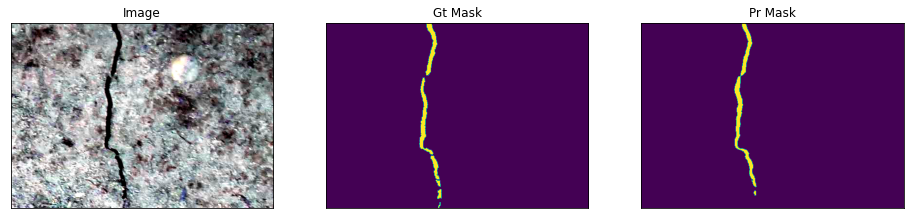

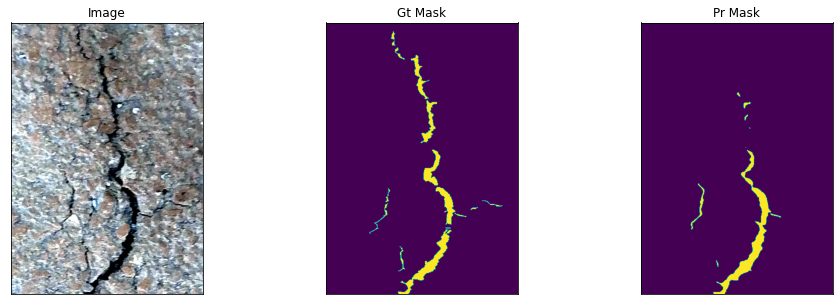

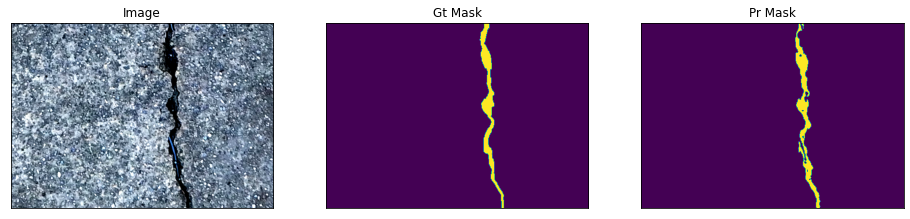

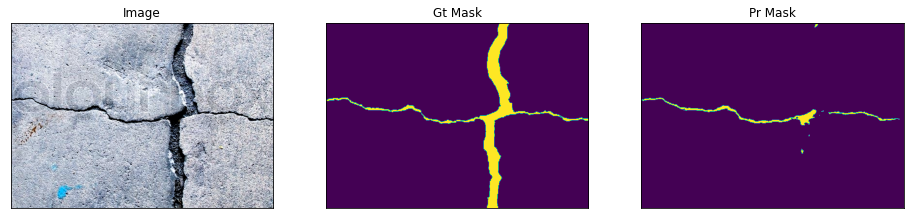

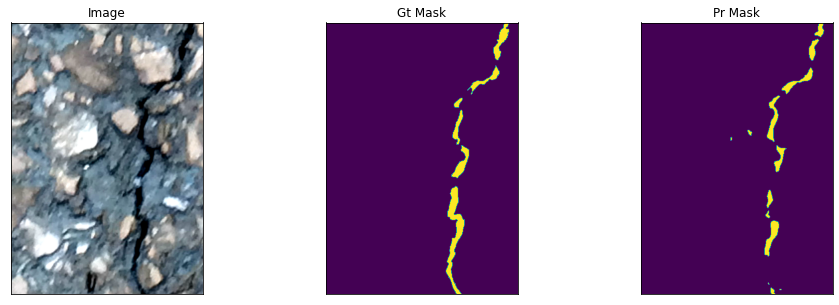

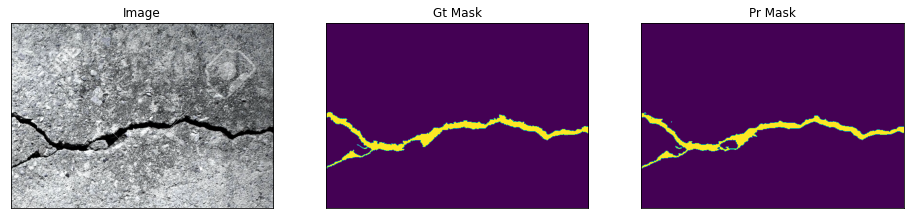

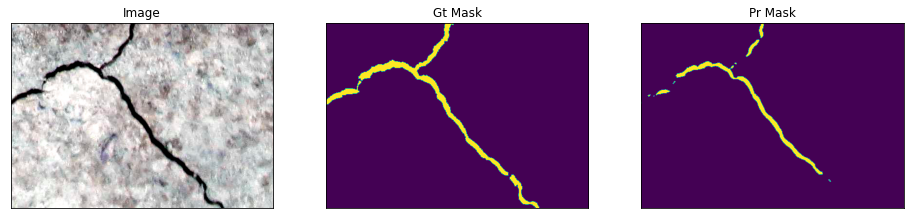

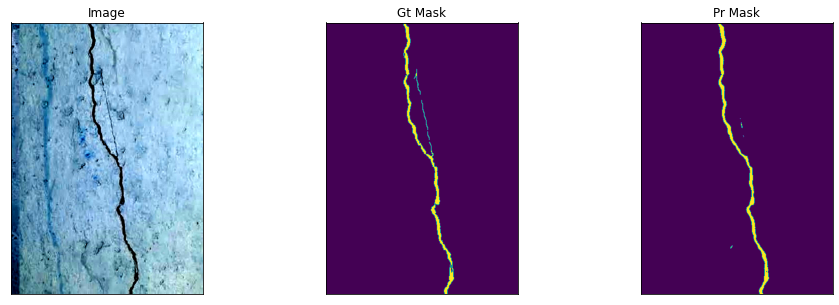

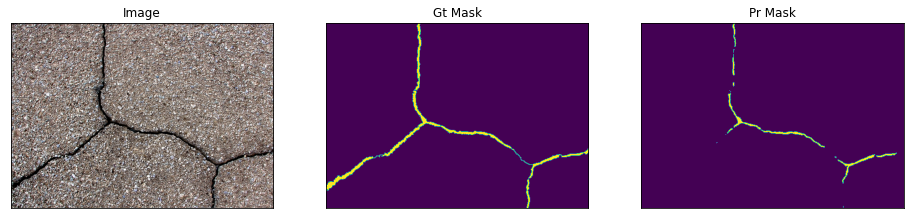

In [ ]:
n = 10
ids = np.random.choice(np.arange(len(dataset_valid)), size=n)

for i in ids:
    image, gt_mask = dataset_valid[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
BACKBONE = 'resnet18' #cambiare
BATCH_SIZE = 4 #aumentare batch

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

# model.load_weights('./drive/My Drive/Colab Notebooks/TACK/data_deepcrack/best_model.h5')
# model.load_weights('./drive/My Drive/Colab Notebooks/TACK/data_deepcrack/best_model_fine_tuned.h5')
model.load_weights('./drive/My Drive/Colab Notebooks/TACK/Small_Tiles/best_model_fine_tuned_with_Small.h5')

44924928/44920640 [==============================] - 2s 0us/step


20
(1024, 1224, 3) (1024, 1224, 1)


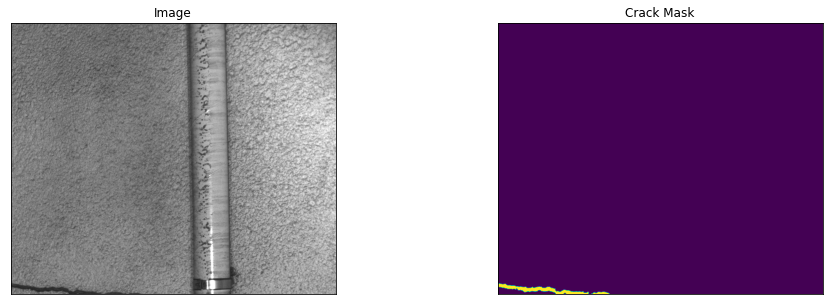

In [ ]:
# DATA_DIR = './drive/My Drive/Colab Notebooks/TACK/Small'
DATA_DIR = './drive/My Drive/Colab Notebooks/TACK/Large'
# DATA_DIR = './drive/My Drive/Colab Notebooks/TACK/NORRA'
x_test_dir = os.path.join(DATA_DIR, 'image')
y_test_dir = os.path.join(DATA_DIR, 'fuse')

dataset_test = Dataset(x_test_dir, y_test_dir, classes=['crack'])
print(len(dataset_test))
image, mask = dataset_test[15] # get some sample
print(image.shape, mask.shape)
visualize(
    image=image, 
    crack_mask=mask[..., 0].squeeze(),
)

In [ ]:
crack_size = []
for i in range(len(dataset_test)):
    image, mask = dataset_test[i]
    crack_size.append(len(mask.astype(np.int8)[mask==1]))
print(crack_size)

[1995, 3443, 2825, 2332, 4072, 2291, 0, 0, 0, 0, 6353, 2961, 0, 0, 0, 0, 3234, 0, 0, 5477, 0, 0, 1960, 607, 0, 4434, 683, 3393, 5666, 0, 13101, 5703, 0, 5850, 9015, 7499, 4156, 943, 0, 4925, 0, 4586, 3611, 1595, 0, 0, 0, 3838, 0, 3406, 11904, 0, 4593, 0, 0, 1324, 6782, 0, 0, 1318, 5270, 2610, 0, 512, 3398, 1395, 6197, 8227, 6535, 1495, 1241, 10305, 2709, 3430, 11555, 6052, 5307, 13430, 6031, 3170, 8962, 8976, 8880, 1824, 3954, 2786, 7359, 1164, 2847, 2583, 2526, 1548, 0, 3714, 8939, 1614, 7375, 10114, 1037, 2239, 1148, 3905, 13263, 2388, 585, 0, 777, 2181, 0, 11696, 0, 0, 0, 2689, 724, 7648, 7807, 0, 935, 8028, 1226, 0, 6454, 3216, 1471, 13774, 13727, 1300, 9507, 13810, 1939, 1851, 7822, 1076, 7053, 1740, 13576, 1461, 4954, 14816, 12682, 13825, 8269, 8626, 7125, 900, 4825, 1465, 1624, 9185, 11466, 7726, 1338, 1963, 4530, 1516, 11282, 2173, 6569, 1598, 1893, 2400, 2030, 5604, 1429, 7549, 2624]


In [ ]:
sorted_id = sorted(range(len(crack_size)), key=lambda k: crack_size[k], reverse=True)
print(sorted)

<built-in function sorted>


In [ ]:
# Histogram Equalization for RGB images
def hisEqulColor(img):
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    channels = cv2.split(ycrcb)
    # print(len(channels))
    cv2.equalizeHist(channels[0], channels[0])
    cv2.merge(channels, ycrcb)
    cv2.cvtColor(ycrcb, cv2.COLOR_YCR_CB2BGR, img)
    return img

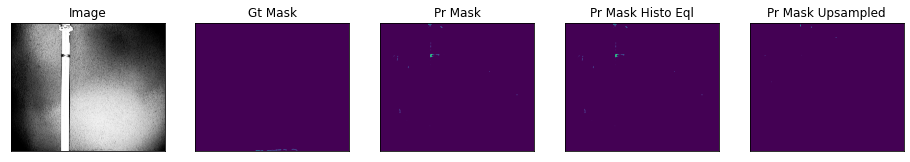

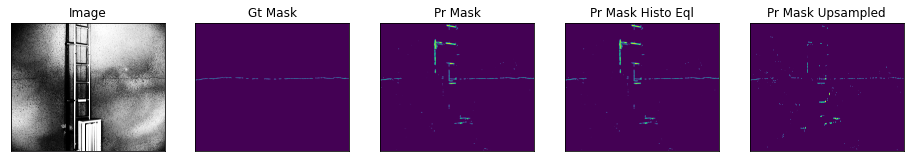

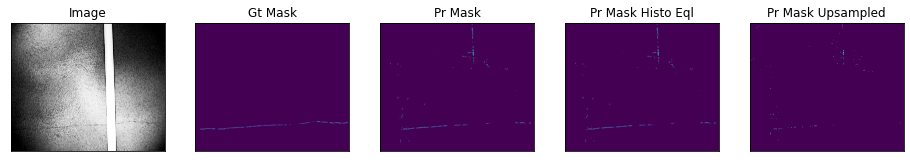

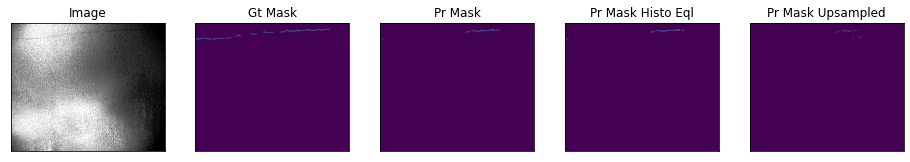

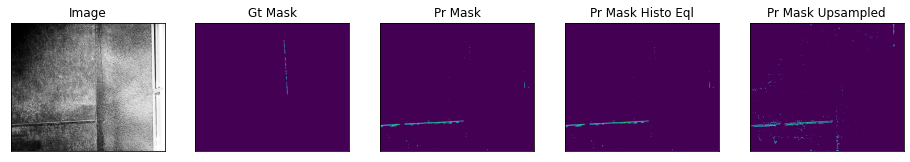

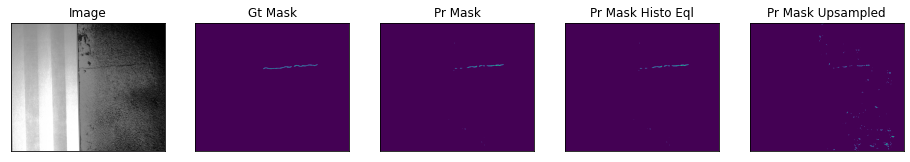

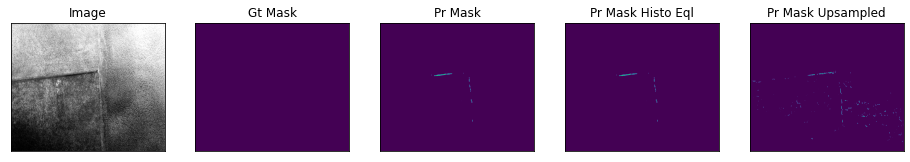

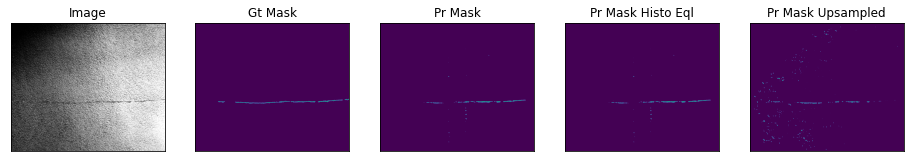

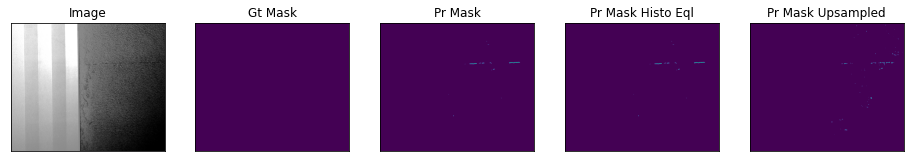

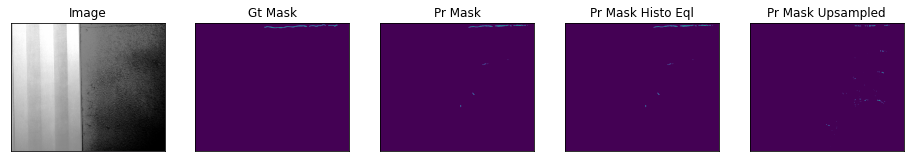

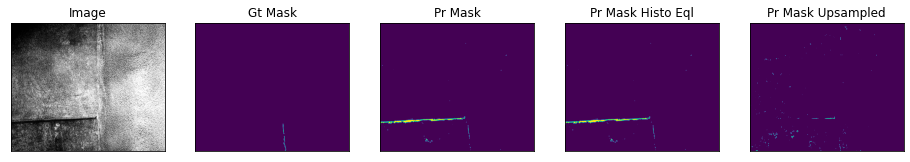

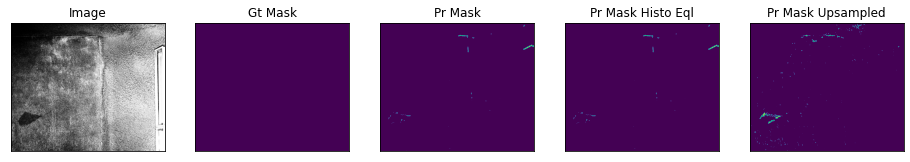

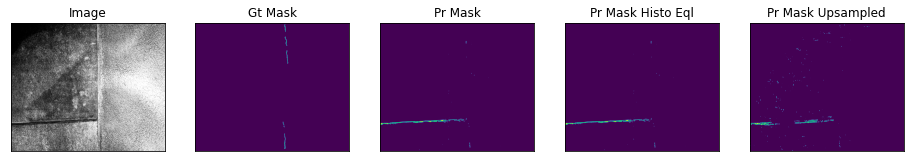

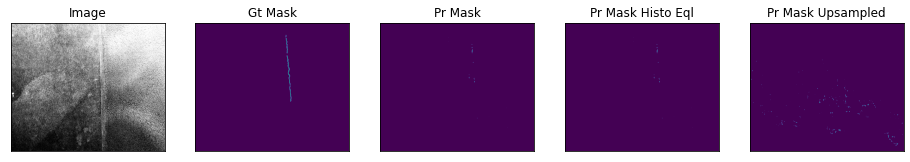

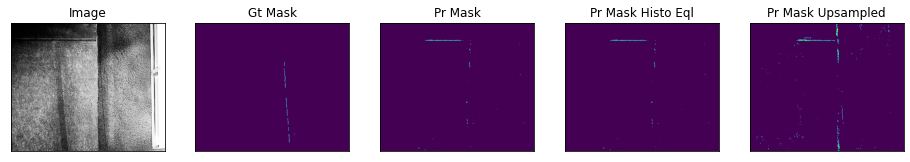

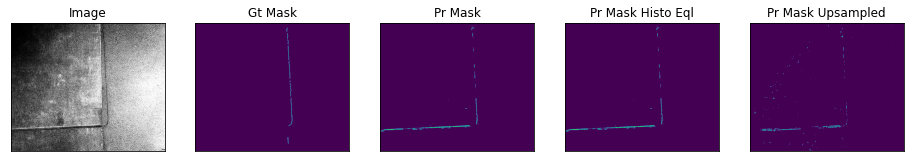

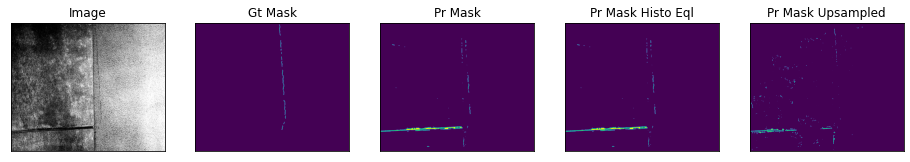

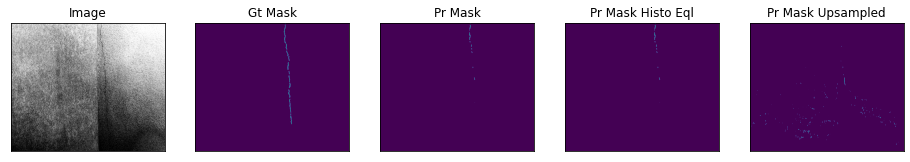

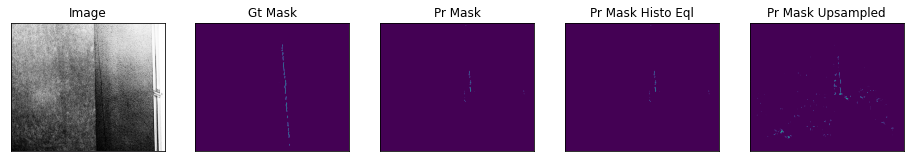

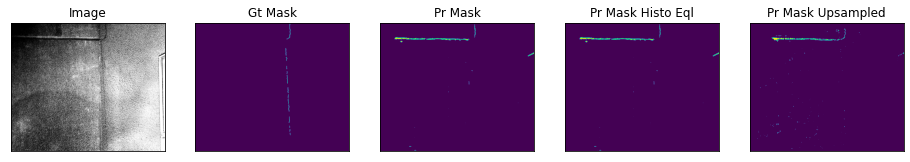

In [ ]:
# Small cracks with Fine Tuned model

n = 20
# ids = np.random.choice(np.arange(len(dataset_test)), size=n)

for id in range(n):
    
    image, gt_mask = dataset_test[id]
    if image.shape[0] < 384 or image.shape[1] < 544:
        print('Error: The testing image is too small')
    
    # print(image.shape)
    # print(gt_mask.shape)

    pr_mask = np.zeros_like(image)
    image_hiseql = hisEqulColor(image)
    pr_mask_histo_eql = np.zeros_like(image_hiseql)
    # print(image_hiseql.shape)
    # print(pr_mask_histo_eql.shape)
    numx = math.ceil(image.shape[1] / 544)
    numy = math.ceil(image.shape[0] / 384)
    # print(numx)
    # print(numy)
    for i in range(numx):
        for j in range(numy):
            if i < numx - 1:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, i*544, (i+1)*544)
                    image_tile = image[j*384: (j+1)*384, i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[j*384: (j+1)*384, i*544: (i+1)*544] = model.predict(image_dim).round()
                    pr_mask_histo_eql[j*384: (j+1)*384, i*544: (i+1)*544] = model.predict(np.expand_dims(image_hiseql[j*384: (j+1)*384, i*544: (i+1)*544], axis=0)).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], i*544, (i+1)*544)
                    image_tile = image[image.shape[0]-384: image.shape[0], i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[image.shape[0]-384: image.shape[0], i*544: (i+1)*544] = model.predict(image_dim).round()
                    pr_mask_histo_eql[image.shape[0]-384: image.shape[0], i*544: (i+1)*544] = model.predict(np.expand_dims(image_hiseql[image.shape[0]-384: image.shape[0], i*544: (i+1)*544], axis=0)).round()
            else:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, image.shape[1]-544, image.shape[1])
                    image_tile = image[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
                    pr_mask_histo_eql[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]] = model.predict(np.expand_dims(image_hiseql[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]], axis=0)).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], image.shape[1]-544, image.shape[1])
                    image_tile = image[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
                    pr_mask_histo_eql[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]] = model.predict(np.expand_dims(image_hiseql[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]], axis=0)).round()

    # print(id)
    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Small/result', str(id)+'_'+'.bmp'), image*255)
    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Small/result', str(id)+'_'+'mask'+'.bmp'), gt_mask*255)
    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Small/result', str(id)+'_'+'prediction'+'.bmp'), pr_mask*255)
    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Small/result', str(id)+'_'+'pred_histoequ'+'.bmp'), pr_mask_histo_eql*255)

    image = cv2.resize(image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    pr_mask_upsampled = np.zeros_like(image)
    numx = math.ceil(image.shape[1] / 544)
    numy = math.ceil(image.shape[0] / 384)
    # print(numx)
    # print(numy)
    for i in range(numx):
        for j in range(numy):
            if i < numx - 1:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, i*544, (i+1)*544)
                    image_tile = image[j*384: (j+1)*384, i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[j*384: (j+1)*384, i*544: (i+1)*544] = model.predict(image_dim).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], i*544, (i+1)*544)
                    image_tile = image[image.shape[0]-384: image.shape[0], i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[image.shape[0]-384: image.shape[0], i*544: (i+1)*544] = model.predict(image_dim).round()
            else:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, image.shape[1]-544, image.shape[1])
                    image_tile = image[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], image.shape[1]-544, image.shape[1])
                    image_tile = image[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Small/result', str(id)+'_'+'pred_upsampled'+'.bmp'), pr_mask_upsampled*255)

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
        pr_mask_histo_eql=pr_mask_histo_eql[..., 0].squeeze(),
        pr_mask_upsampled=pr_mask_upsampled[..., 0].squeeze()
    )

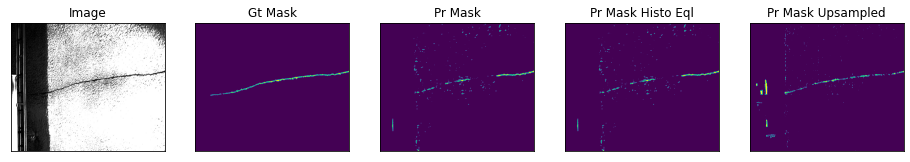

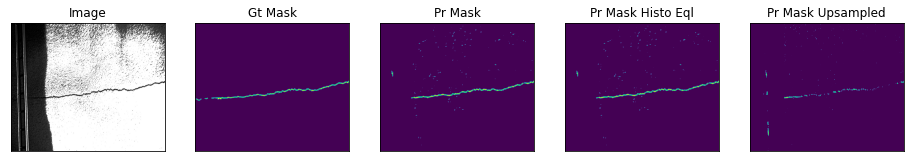

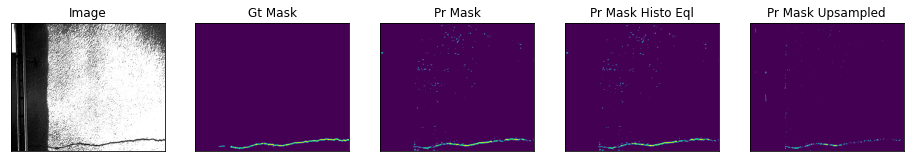

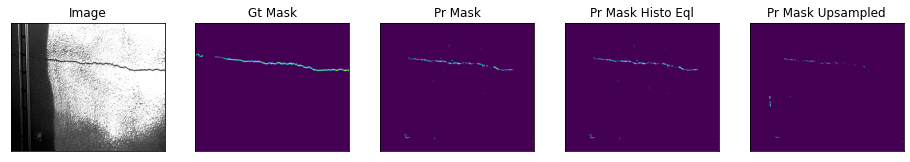

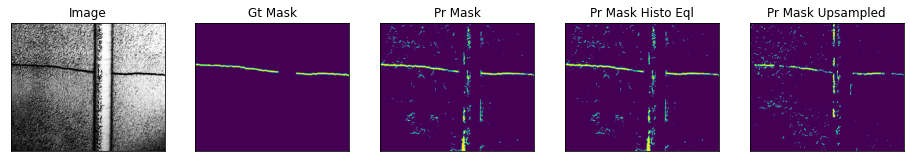

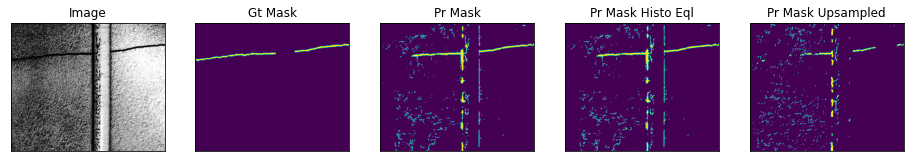

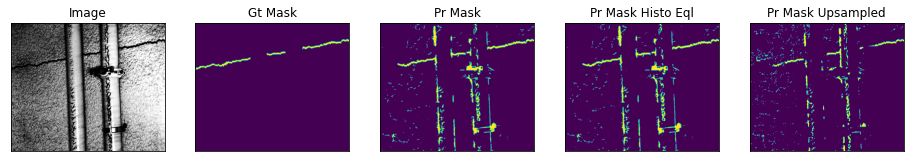

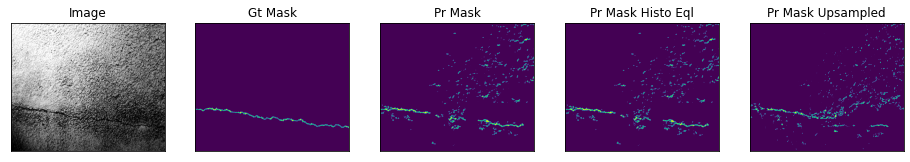

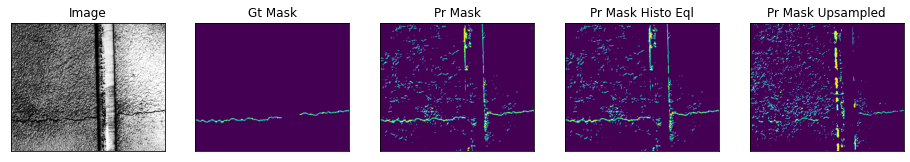

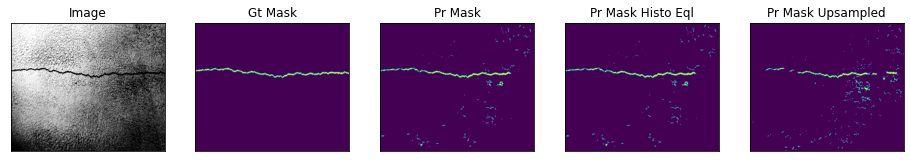

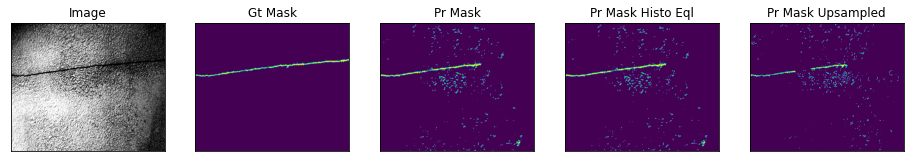

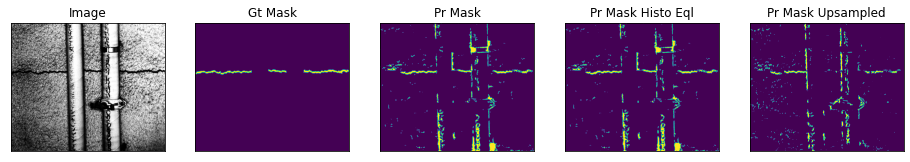

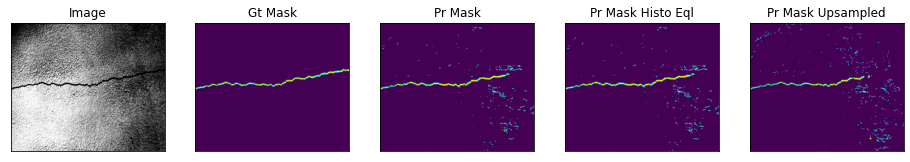

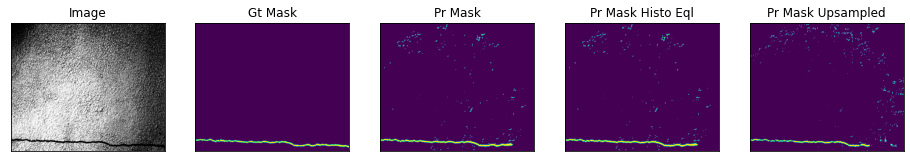

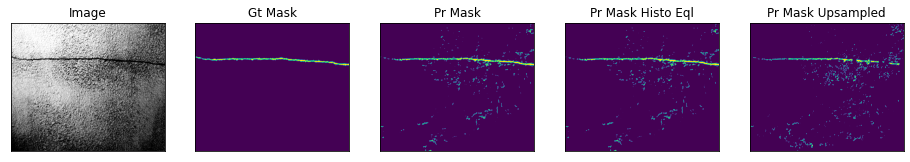

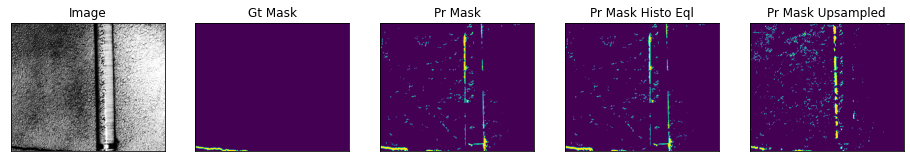

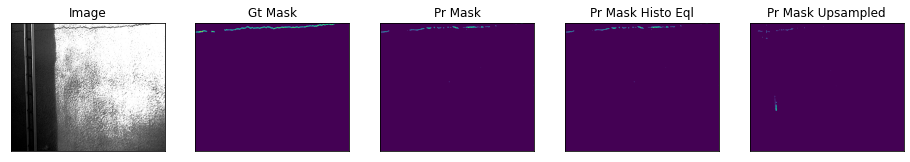

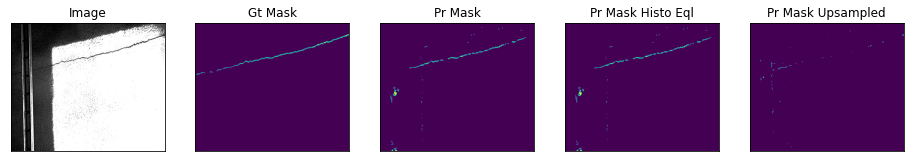

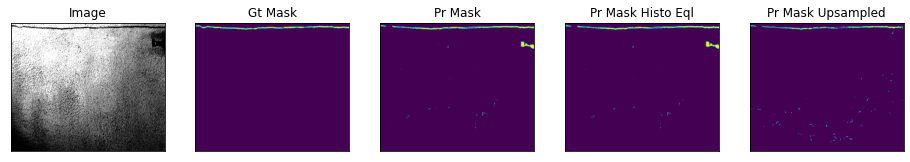

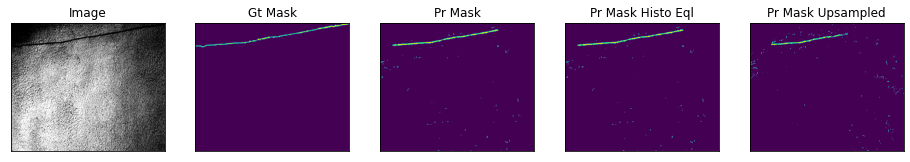

In [ ]:
# Large cracks with Fine Tuned model

n = 20
# ids = np.random.choice(np.arange(len(dataset_test)), size=n)

for id in range(n):
    
    image, gt_mask = dataset_test[id]
    if image.shape[0] < 384 or image.shape[1] < 544:
        print('Error: The testing image is too small')
        continue
    
    # print(image.shape)
    # print(gt_mask.shape)

    pr_mask = np.zeros_like(image)
    image_hiseql = hisEqulColor(image)
    pr_mask_histo_eql = np.zeros_like(image_hiseql)
    # print(image_hiseql.shape)
    # print(pr_mask_histo_eql.shape)
    numx = math.ceil(image.shape[1] / 544)
    numy = math.ceil(image.shape[0] / 384)
    # print(numx)
    # print(numy)
    for i in range(numx):
        for j in range(numy):
            if i < numx - 1:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, i*544, (i+1)*544)
                    image_tile = image[j*384: (j+1)*384, i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[j*384: (j+1)*384, i*544: (i+1)*544] = model.predict(image_dim).round()
                    pr_mask_histo_eql[j*384: (j+1)*384, i*544: (i+1)*544] = model.predict(np.expand_dims(image_hiseql[j*384: (j+1)*384, i*544: (i+1)*544], axis=0)).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], i*544, (i+1)*544)
                    image_tile = image[image.shape[0]-384: image.shape[0], i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[image.shape[0]-384: image.shape[0], i*544: (i+1)*544] = model.predict(image_dim).round()
                    pr_mask_histo_eql[image.shape[0]-384: image.shape[0], i*544: (i+1)*544] = model.predict(np.expand_dims(image_hiseql[image.shape[0]-384: image.shape[0], i*544: (i+1)*544], axis=0)).round()
            else:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, image.shape[1]-544, image.shape[1])
                    image_tile = image[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
                    pr_mask_histo_eql[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]] = model.predict(np.expand_dims(image_hiseql[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]], axis=0)).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], image.shape[1]-544, image.shape[1])
                    image_tile = image[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
                    pr_mask_histo_eql[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]] = model.predict(np.expand_dims(image_hiseql[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]], axis=0)).round()

    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Large/result', str(id)+'_'+'.bmp'), image)
    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Large/result', str(id)+'_'+'mask'+'.bmp'), gt_mask*255)
    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Large/result', str(id)+'_'+'prediction'+'.bmp'), pr_mask*255)
    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Large/result', str(id)+'_'+'pred_histoequ'+'.bmp'), pr_mask_histo_eql*255)

    image = cv2.resize(image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    pr_mask_upsampled = np.zeros_like(image)
    numx = math.ceil(image.shape[1] / 544)
    numy = math.ceil(image.shape[0] / 384)
    # print(numx)
    # print(numy)
    for i in range(numx):
        for j in range(numy):
            if i < numx - 1:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, i*544, (i+1)*544)
                    image_tile = image[j*384: (j+1)*384, i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[j*384: (j+1)*384, i*544: (i+1)*544] = model.predict(image_dim).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], i*544, (i+1)*544)
                    image_tile = image[image.shape[0]-384: image.shape[0], i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[image.shape[0]-384: image.shape[0], i*544: (i+1)*544] = model.predict(image_dim).round()
            else:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, image.shape[1]-544, image.shape[1])
                    image_tile = image[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], image.shape[1]-544, image.shape[1])
                    image_tile = image[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
    
    cv2.imwrite(os.path.join('./drive/My Drive/Colab Notebooks/TACK/Large/result', str(id)+'_'+'pred_upsampled'+'.bmp'), pr_mask_upsampled*255)
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
        pr_mask_histo_eql=pr_mask_histo_eql[..., 0].squeeze(),
        pr_mask_upsampled=pr_mask_upsampled[..., 0].squeeze()
    )

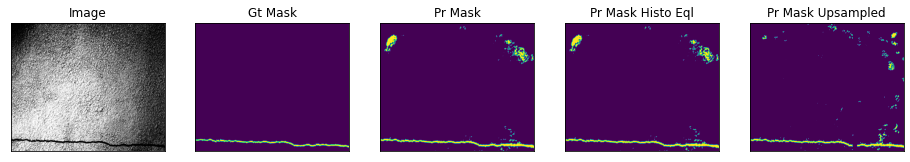

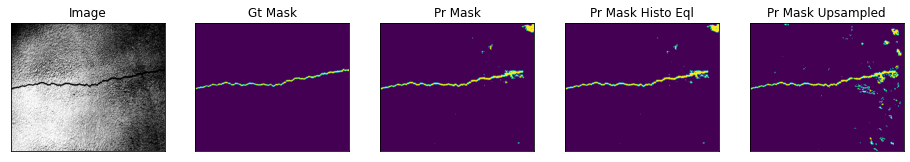

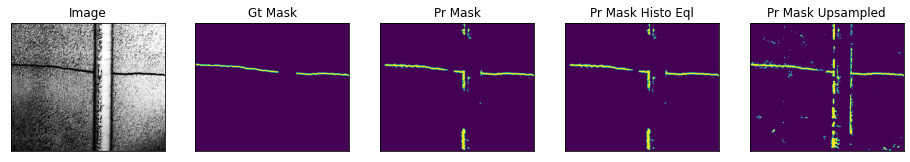

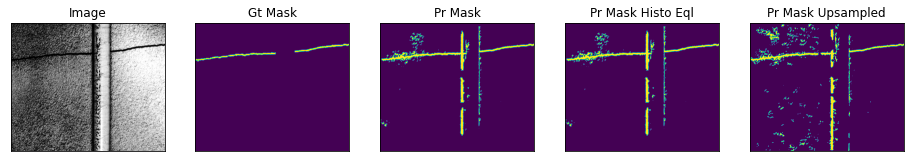

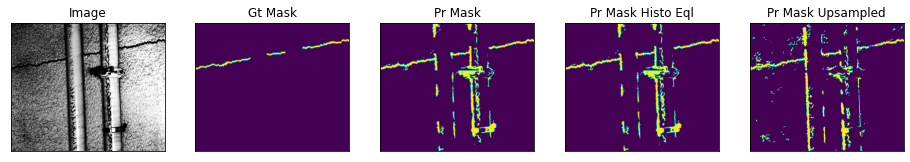

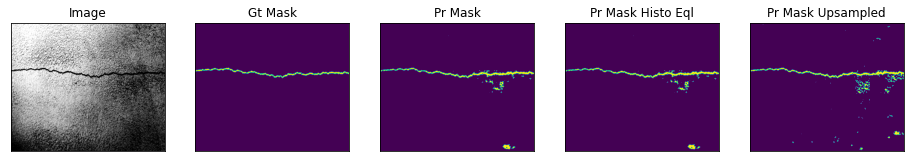

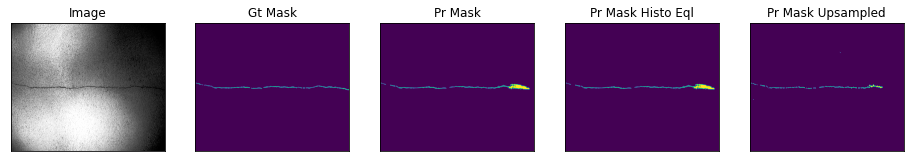

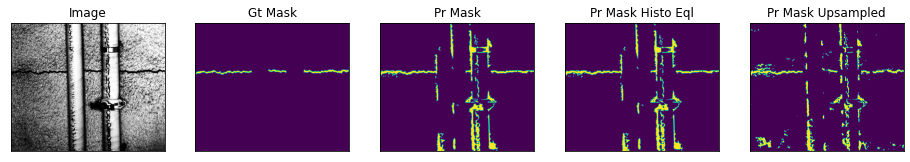

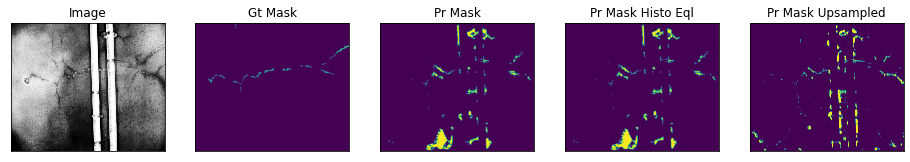

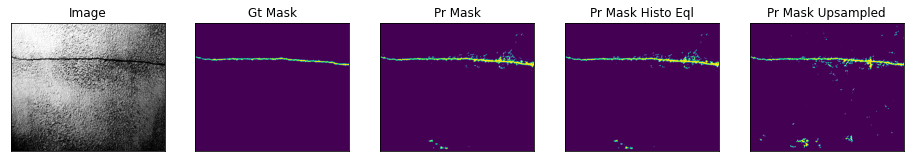

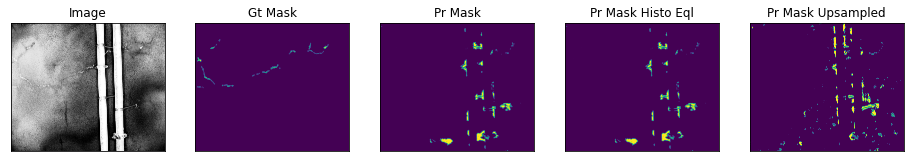

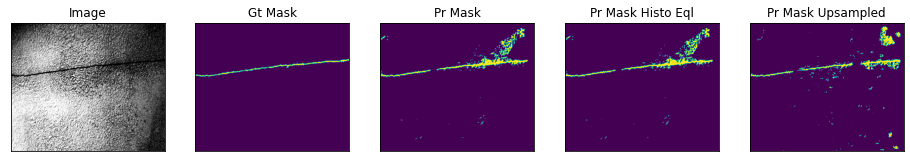

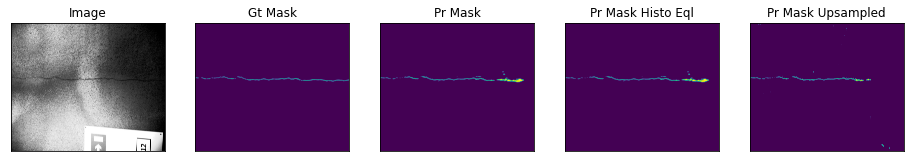

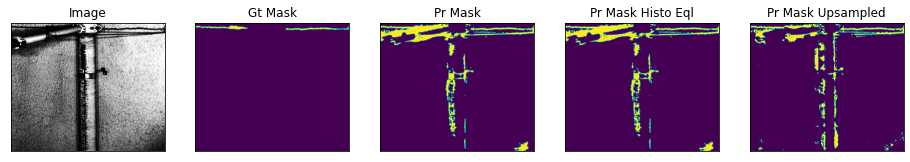

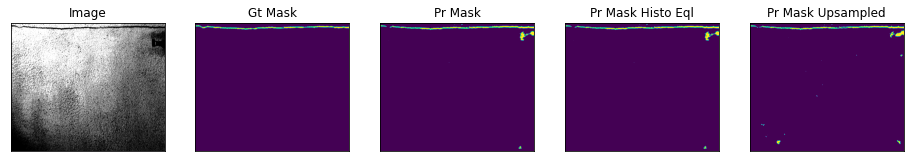

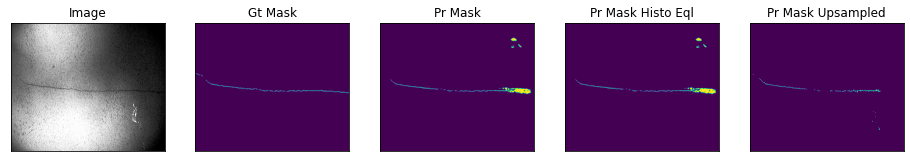

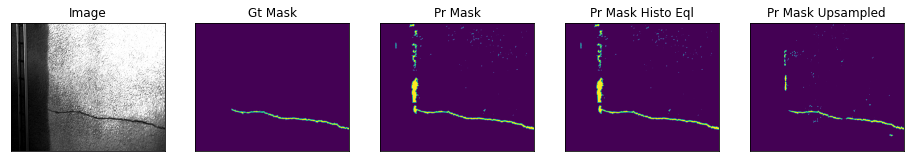

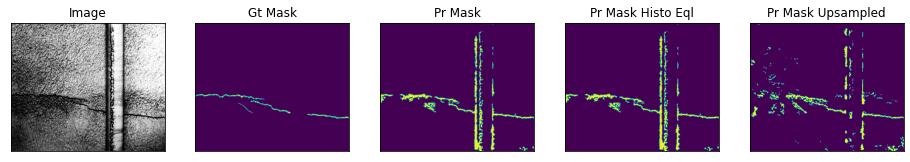

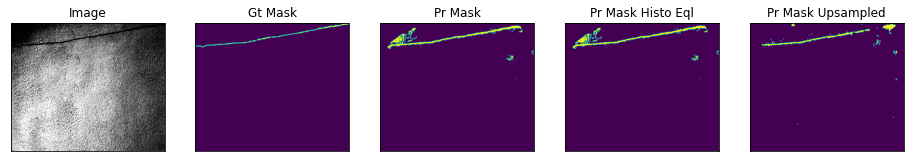

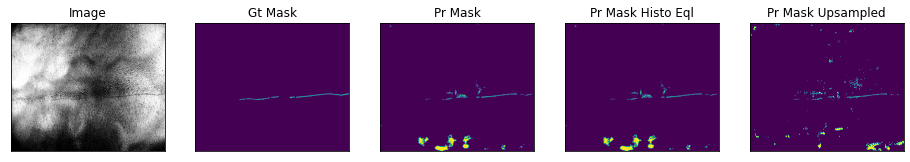

In [ ]:
# Cracks with Fine Tuned model

n = 20

for i in sorted_id[0:n]:
    
    image, gt_mask = dataset_test[i]
    if image.shape[0] < 384 or image.shape[1] < 544:
        print('Error: The testing image is too small')
    
    # print(image.shape)
    # print(gt_mask.shape)

    pr_mask = np.zeros_like(image)
    image_hiseql = hisEqulColor(image)
    pr_mask_histo_eql = np.zeros_like(image_hiseql)
    # print(image_hiseql.shape)
    # print(pr_mask_histo_eql.shape)
    numx = math.ceil(image.shape[1] / 544)
    numy = math.ceil(image.shape[0] / 384)
    # print(numx)
    # print(numy)
    for i in range(numx):
        for j in range(numy):
            if i < numx - 1:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, i*544, (i+1)*544)
                    image_tile = image[j*384: (j+1)*384, i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[j*384: (j+1)*384, i*544: (i+1)*544] = model.predict(image_dim).round()
                    pr_mask_histo_eql[j*384: (j+1)*384, i*544: (i+1)*544] = model.predict(np.expand_dims(image_hiseql[j*384: (j+1)*384, i*544: (i+1)*544], axis=0)).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], i*544, (i+1)*544)
                    image_tile = image[image.shape[0]-384: image.shape[0], i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[image.shape[0]-384: image.shape[0], i*544: (i+1)*544] = model.predict(image_dim).round()
                    pr_mask_histo_eql[image.shape[0]-384: image.shape[0], i*544: (i+1)*544] = model.predict(np.expand_dims(image_hiseql[image.shape[0]-384: image.shape[0], i*544: (i+1)*544], axis=0)).round()
            else:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, image.shape[1]-544, image.shape[1])
                    image_tile = image[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
                    pr_mask_histo_eql[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]] = model.predict(np.expand_dims(image_hiseql[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]], axis=0)).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], image.shape[1]-544, image.shape[1])
                    image_tile = image[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
                    pr_mask_histo_eql[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]] = model.predict(np.expand_dims(image_hiseql[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]], axis=0)).round()

    image = cv2.resize(image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    pr_mask_upsampled = np.zeros_like(image)
    numx = math.ceil(image.shape[1] / 544)
    numy = math.ceil(image.shape[0] / 384)
    # print(numx)
    # print(numy)
    for i in range(numx):
        for j in range(numy):
            if i < numx - 1:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, i*544, (i+1)*544)
                    image_tile = image[j*384: (j+1)*384, i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[j*384: (j+1)*384, i*544: (i+1)*544] = model.predict(image_dim).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], i*544, (i+1)*544)
                    image_tile = image[image.shape[0]-384: image.shape[0], i*544: (i+1)*544]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[image.shape[0]-384: image.shape[0], i*544: (i+1)*544] = model.predict(image_dim).round()
            else:
                if j < numy - 1:
                    # print(j*384, (j+1)*384, image.shape[1]-544, image.shape[1])
                    image_tile = image[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[j*384: (j+1)*384, image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
                else:
                    # print(image.shape[0]-384, image.shape[0], image.shape[1]-544, image.shape[1])
                    image_tile = image[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]]
                    # print(image_tile.shape)
                    image_dim = np.expand_dims(image_tile, axis=0)
                    pr_mask_upsampled[image.shape[0]-384: image.shape[0], image.shape[1]-544: image.shape[1]] = model.predict(image_dim).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
        pr_mask_histo_eql=pr_mask_histo_eql[..., 0].squeeze(),
        pr_mask_upsampled=pr_mask_upsampled[..., 0].squeeze()
    )

In [ ]:
dataset_test = Dataset(x_fine_tune_dir, y_fine_tune_dir, classes=['crack'])
test_dataloader = Dataloder(dataset_test, batch_size=1, shuffle=False)
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))


Loss: 0.74946
mean iou_score: 0.27143
mean f1-score: 0.38495
